In [198]:
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import random
from math import floor

In [204]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [178]:
good = pd.read_csv('good.csv')
purchase_good = pd.read_csv('purchase_good.csv')
user_purchase = pd.read_csv('user_purchase.csv')
user_ab_group = pd.read_csv('user_ab_group.csv')

<font size='5'>Прежде чем приступим к Анализу данных, необходимо убедиться в том, что A/B тест смоделирован правильно. (Проверка на наличие ошибки Sample Ratio Mismatch)<font>

In [184]:
our_diff = sum(user_ab_group['group']=='treatment')-sum(user_ab_group['group']=='control')

In [185]:
our_diff

65

In [201]:
diffs = []
for _ in range(1_000):
    arr = [random.randint(0,1) for i in range(len(user_ab_group))]
    diff = sum(arr) - (len(arr)-sum(arr))
    diffs.append(diff)
diffs_s = pd.Series(diffs)

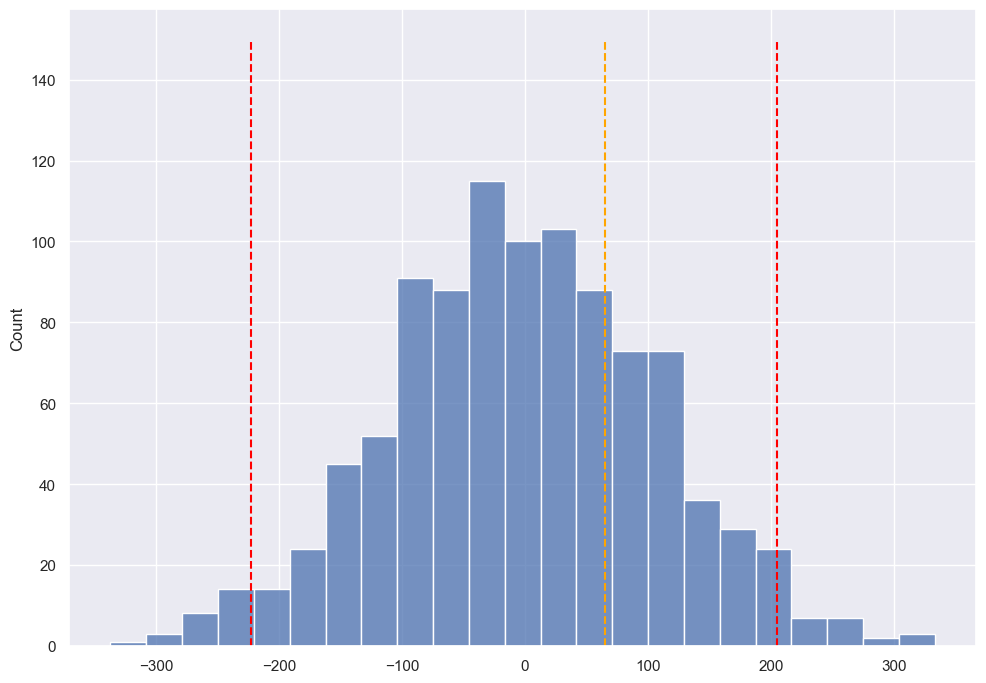

In [205]:
ax = sns.histplot(diffs)

alpha = 0.05
half_alpha = floor(len(diffs_s) * alpha / 2)
diffs_cut = sorted(diffs_s)[half_alpha:-half_alpha]
ax.vlines([our_diff], 0, 150, linestyles='dashed', color='orange')
ax.vlines([diffs_cut[0], diffs_cut[-1]], 0, 150, linestyles='dashed', color='red')

<font size='3'>Ошибки SRM с большой вероятностью нет. Значит можем приступить к самому анализу данных.<font>

<font size="6">Предобработка данных</font>

In [91]:
user_purchase['date_time'] = pd.to_datetime(user_purchase['date_time'])
user_purchase = user_purchase[ user_purchase['date_time'].between('2023-10-01','2023-10-15') ]
user_purchase = user_purchase.rename(columns={'id':'purchase_id'})
user_ab_group = pd.merge(user_ab_group,user_purchase, on='user_id', how='left')

user_ab_group = pd.merge(user_ab_group,purchase_good, on='purchase_id',how='left')

good = good.rename(columns={'id':'good_id'})
user_ab_group = pd.merge(user_ab_group,good, on='good_id',how='left')

user_ab_group.drop(columns=['good_name','date_time'],inplace=True)

control_group = user_ab_group[user_ab_group['group'] == 'control'].copy()
control_group.drop(columns=['group'],inplace=True)
control_group = control_group.fillna(0)
experimental_group = user_ab_group[user_ab_group['group'] == 'treatment'].copy()
experimental_group.drop(columns=['group'],inplace=True)
experimental_group = experimental_group.fillna(0)

In [92]:
control_group['cost'] = control_group['amount']*control_group['price_per_unit']
experimental_group['cost'] = experimental_group['amount']*experimental_group['price_per_unit']

In [93]:
control_group.sort_values(by='cost')

,user_id,purchase_id,good_id,amount,was_in_recommended_goods,price_per_unit,cost
26879,13869,0.0,0.0,0.0,0,0.0,0.0
16072,3378,0.0,0.0,0.0,0,0.0,0.0
4800,9437,0.0,0.0,0.0,0,0.0,0.0
55197,10800,0.0,0.0,0.0,0,0.0,0.0
55196,3465,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
23623,10253,22139.0,2.0,3.0,False,796.0,2388.0
19134,7817,22192.0,2.0,3.0,False,796.0,2388.0
13765,697,14500.0,2.0,3.0,True,796.0,2388.0
44831,11031,20078.0,54.0,4.0,False,647.0,2588.0


In [ ]:
experimental_group.sort_values(by='cost')

<font size="6">Данные предобработаны, теперь приступаем к вычислению метрик.</font>

<font size='4'>Рассчитаем ключевую метрику - средняя выручка с пользователя (ARPU) для всех его покупок<font>

In [137]:
ARPU_all_control_group = control_group.groupby('user_id').agg({'cost':'sum'})['cost']
ARPU_all_experimental_group = experimental_group.groupby('user_id').agg({'cost':'sum'})['cost']

In [162]:
ARPU_all_control_group.mean()

np.float64(2643.119493670886)

In [164]:
ARPU_all_experimental_group.mean()

np.float64(4427.101001669449)

In [266]:
t_stat1, p_value1 = stats.ttest_ind(ARPU_all_control_group,ARPU_all_experimental_group, equal_var=False)

In [267]:
t_stat1

np.float64(-24.233967540582896)

In [268]:
p_value1

np.float64(3.3634787988538025e-126)

<font size='4'>Отвергаем нулевую гипотезу. Рост ARPU статистически значим.<font>

<font size='3'>Ниже графики распределения суммы чеков для обеих групп. Можно заметить, что в экспериментальной группе оно сместилось вправо.<font>

<Axes: xlabel='cost', ylabel='Count'>

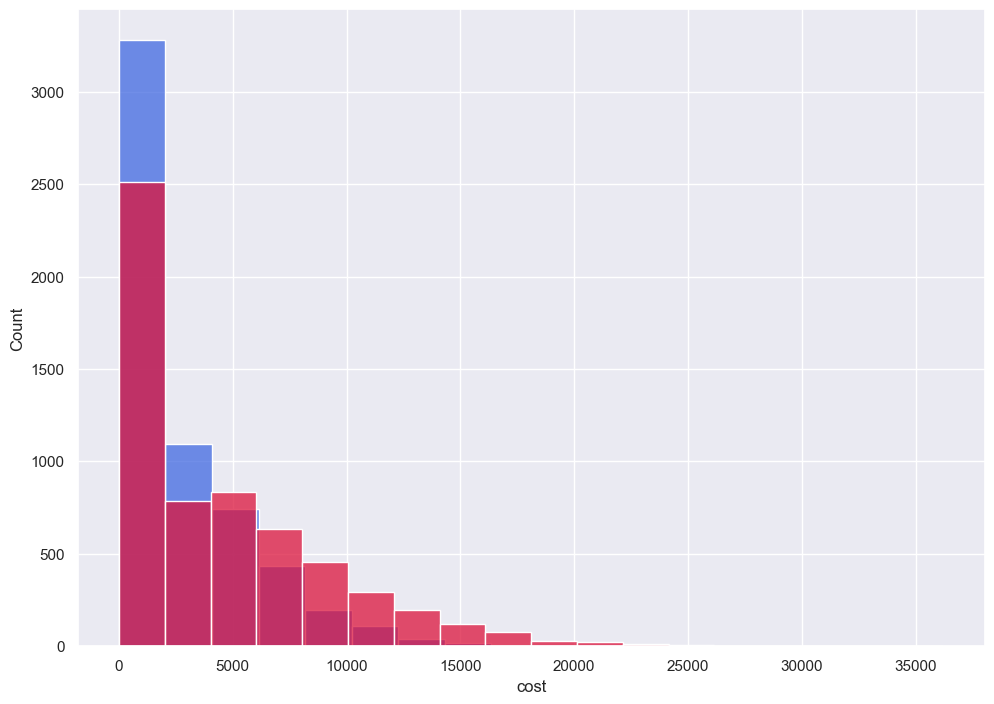

In [206]:
sns.histplot(control_group.groupby('user_id').agg({'cost':'sum'}).reset_index(),x='cost',binwidth=2000,color='royalblue')
sns.histplot(experimental_group.groupby('user_id').agg({'cost':'sum'}).reset_index(),x='cost',binwidth=2000,color='crimson')

<font size='6'>Интерпретация результата.<font>

<font size='5'>Посчитаем долю выручки, полученной благодаря рекомендациям для каждого человека, и возьмем от этого среднее.<font>

In [15]:
recommended_goods_control_group = control_group[control_group['was_in_recommended_goods']]
recommended_goods_experimental_group = experimental_group[experimental_group['was_in_recommended_goods']]

In [16]:
a = recommended_goods_control_group.groupby('user_id').agg({'cost':'sum'})/control_group.groupby('user_id').agg({'cost':'sum'})
a = a.fillna(0)
a.mean()

cost    0.297883
dtype: float64

In [17]:
b = recommended_goods_experimental_group.groupby('user_id').agg({'cost':'sum'})/experimental_group.groupby('user_id').agg({'cost':'sum'})
b = b.fillna(0)
b.mean()

cost    0.449987
dtype: float64

In [263]:
t_stat2, p_value2 = stats.ttest_ind(a, b, equal_var=False)

In [264]:
t_stat2

array([-26.53804433])

In [265]:
p_value2

array([3.87081306e-149])

<font size='3'>Отвергаем нулевую гипотезу. Рост доли выручки с рекомендаций статистически значим.<font>

<font size='5'>Рассмотрим среднее количество товаров, покупаемых пользователем.<font>

In [238]:
avg_cnt_control_group = control_group.groupby(['user_id','purchase_id']).agg({'amount':'sum'}).reset_index().groupby('user_id').agg({'amount':'mean'}).reset_index()
avg_cnt_experimental_group = experimental_group.groupby(['user_id','purchase_id']).agg({'amount':'sum'}).reset_index().groupby('user_id').agg({'amount':'mean'}).reset_index()

<Axes: xlabel='amount', ylabel='Count'>

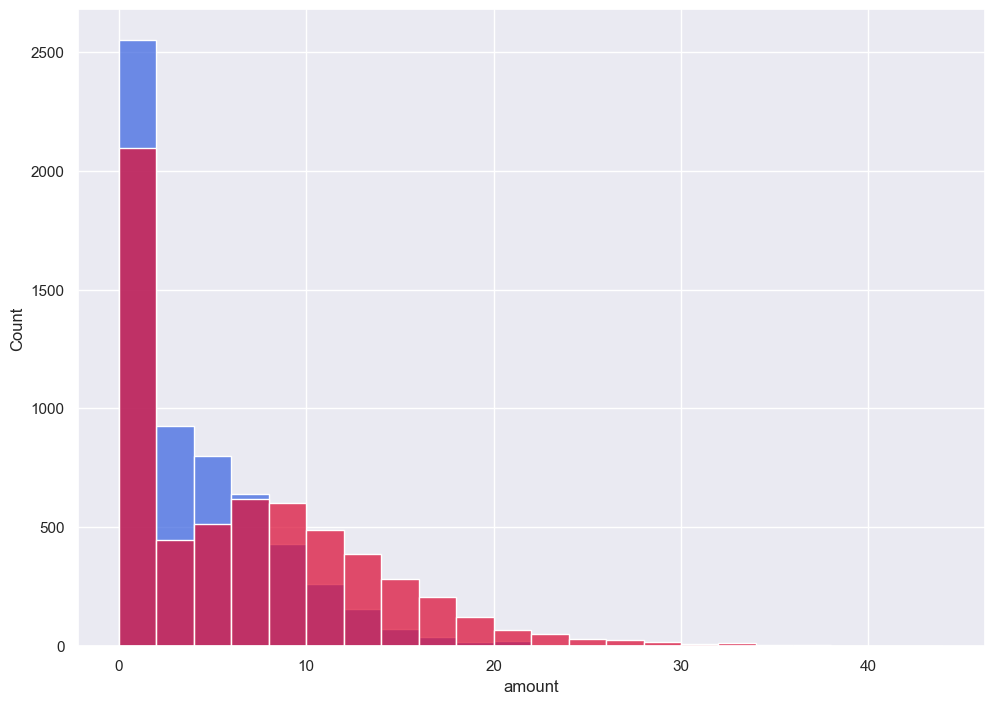

In [250]:
sns.histplot(avg_cnt_control_group,x='amount',binwidth=2,color='royalblue')
sns.histplot(avg_cnt_experimental_group,x='amount',binwidth=2,color='crimson')

In [254]:
t_stat3, p_value3 = stats.ttest_ind(avg_cnt_control_group['amount'],avg_cnt_experimental_group['amount'],equal_var=False)

In [255]:
t_stat3

np.float64(-27.29912284419605)

In [256]:
p_value3

np.float64(2.4289496995165406e-158)

<font size='3'>Отвергаем нулевую гипотезу. Рост среднего количества товаров, покупаемых пользователем статистически значим.<font>

<font size="5">Посчитаем теперь среднюю долю рекомендованных товаров в покупках по чекам. (precision)</font>

In [152]:
precision_A = (recommended_goods_control_group.groupby('purchase_id').agg({'amount':'sum'})/control_group.groupby('purchase_id').agg({'amount':'sum'})).fillna(0).rename(columns={'amount':'precision'})
precision_control_group = precision_A.mean()
precision_B = (recommended_goods_experimental_group.groupby('purchase_id').agg({'amount':'sum'})/experimental_group.groupby('purchase_id').agg({'amount':'sum'})).fillna(0).rename(columns={'amount':'precision'})
precision_experimental_group = precision_B.mean()

<font size='3'>Ниже графики распределения precision для обеих групп. Можно увидеть выразительный прирост значения этой метрики в экспериментальной группе по сравнению с контрольной.<font>

<Axes: xlabel='precision', ylabel='Count'>

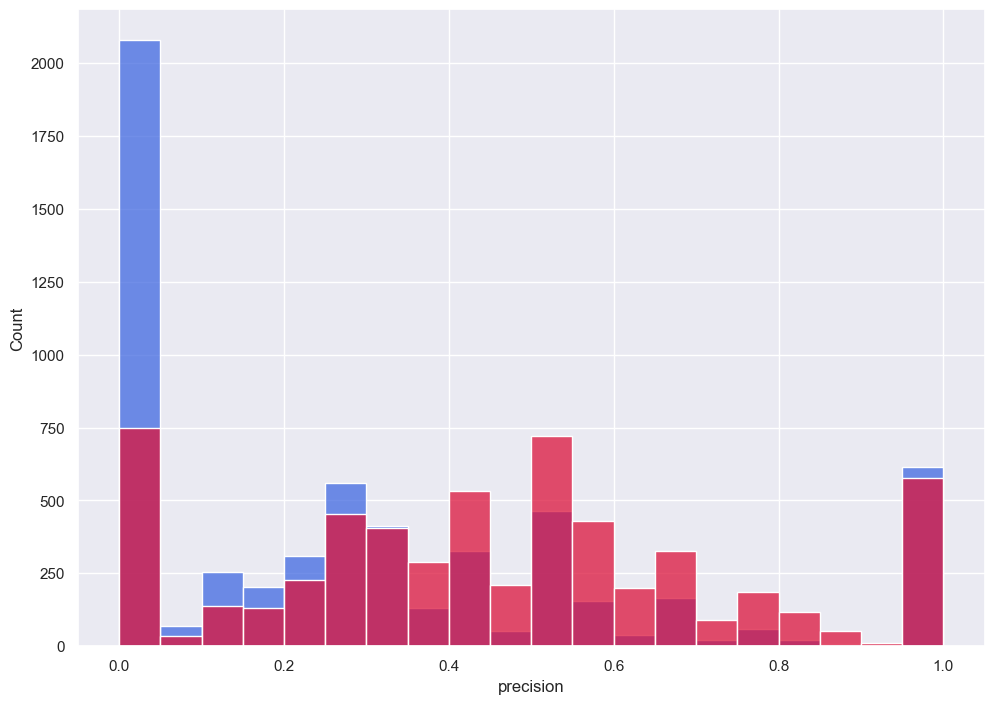

In [257]:
sns.histplot(precision_A.reset_index(),x='precision',binwidth=0.05,color='royalblue')
sns.histplot(precision_B.reset_index(),x='precision',binwidth=0.05,color='crimson')

In [258]:
precision_control_group

precision    0.300607
dtype: float64

In [259]:
precision_experimental_group

precision    0.453739
dtype: float64

In [260]:
t_stat4, p_value4 = stats.ttest_ind(precision_A, precision_B,equal_var=False)

In [261]:
t_stat[0]

np.float64(-26.53804432935587)

In [262]:
p_value[0]

np.float64(3.8708130569174915e-149)

<font size='3'>Отвергаем нулевую гипотезу. Наблюдаемый рост precision статистически значим — данные поддерживают предположение о его наличии.<font>

<font size='6'>Итог<font>

<font size='4.5'>Новая рекомендательная система статистически значимо увеличила среднюю выручку (ARPU) по сравнению со старой. Рост ARPU связан с увеличением среднего числа покупок и доли рекомендованных товаров в корзине.<font>